In [3]:
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

In [15]:
import gym
import moviepy
import tqdm
import random
import numpy as np
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import os
import moviepy.editor as mpy
from IPython.display import Video
from moviepy.editor import VideoFileClip, concatenate_videoclips
from gym.wrappers.record_video import RecordVideo
from ipywidgets import FileUpload
%matplotlib inline


#### Buffer for experience replay

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = self.transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

#### Noise generated by the Ornstein-Uhlenbeck Process

In [6]:
class Noise:
    def __init__(self, params):
        self.mu = params.mu
        self.theta = params.theta
        self.sigma = params.sigma
        self.reset()

    def reset(self):
        self.state = np.full(params.action_dim, self.mu)

    def make_noise(self):
        state = self.state
        delta = self.theta *(self.mu - state) + self.sigma * np.random.randn(len(state))
        self.state = state + delta
        return self.state

#### Classes for Actor and Critic networks and the general model - Model

In [7]:
class Actor(nn.Module):
    def __init__(self, params):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(params.state_dim,  params.act_hid_1)
        self.fc2 = nn.Linear(params.act_hid_1, params.act_hid_2)
        self.fc3 = nn.Linear(params.act_hid_2,  params.action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    def __init__(self, params):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(params.state_dim, params.crit_hid_1)
        self.fc2 = nn.Linear(params.crit_hid_1 + params.action_dim, params.crit_hid_2)
        self.fc3 = nn.Linear(params.crit_hid_2, 1)

    def forward(self, x, action):
        x = F.relu(self.fc1(x))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Model:
    def __init__(self, params):

        self.device = params.device

        self.actor = Actor(params).to(self.device)
        self.actor_target = Actor(params).to(self.device)
        self.critic = Critic(params).to(self.device)
        self.critic_target = Critic(params).to(self.device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=params.lr_actor)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=params.lr_critic)

        self.tau_actor = params.tau_actor
        self.tau_critic = params.tau_critic

        self.__update(self.actor_target, self.actor)
        self.__update(self.critic_target, self.critic)

    def __update(self, target, local):
        target.load_state_dict(local.state_dict())

    def __soft_update(self, target, local, tau):
        for target_param, param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def update_target_nn(self):
        self.__soft_update(self.actor_target, self.actor, self.tau_actor)
        self.__soft_update(self.critic_target, self.critic, self.tau_critic)

#### Class for DDPG

In [8]:
class DDPG:
    def __init__(self, params):

        self.device = params.device
        self.gamma = params.gamma
        self.batch_size = params.batch_size
        self.act_up, self.act_down = params.act_up, params.act_down

        self.explor_noise = Noise(params)
        self.buffer = ReplayBuffer(params.buffer_size)
        self.model = Model(params)


    def update(self):
        if len(self.buffer) <= self.batch_size:
            return

        transitions = self.buffer.sample(self.batch_size)
        batch = self.buffer.transition(*zip(*transitions))

        state_batch = self.tensor(batch.state).float()
        action_batch = self.tensor(batch.action).float()
        reward_batch = self.tensor(batch.reward).float()
        next_state_batch = self.tensor(batch.next_state).float()

        with torch.no_grad():
            next_actions = self.model.actor_target(next_state_batch)
        Q_next = self.model.critic_target(next_state_batch, next_actions).detach()

        reward_batch = reward_batch.unsqueeze(1)
        not_terminate_batch = ~torch.tensor(batch.done).to(self.device).unsqueeze(1)

        Q = self.model.critic(state_batch, action_batch)
        Q_expected = reward_batch + self.gamma * Q_next * not_terminate_batch

        L = F.mse_loss(Q, Q_expected)
        self.model.critic_optimizer.zero_grad()
        L.backward()
        for param in self.model.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.critic_optimizer.step()

        a = self.model.actor(state_batch)
        L_policy = - self.model.critic(state_batch, a).mean()
        self.model.actor_optimizer.zero_grad()
        L_policy.backward()
        for param in self.model.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.actor_optimizer.step()

        self.model.update_target_nn()

    def act(self, state, eps=0):
        state = self.tensor(state).float().unsqueeze(0)
        with torch.no_grad():
            action = self.model.actor(state)
        return np.clip(action.item() + eps*self.explor_noise.make_noise(), self.act_down, self.act_up)

    def reset(self):
        self.explor_noise.reset()

    def tensor(self, x):
        return torch.tensor(x).to(self.device)

####  Agent training and testing

In [9]:
def training_agent(params, agent):
    rewards = []
    for i in range(1, params.episodes+1):
        state = env.reset()
        agent.reset()
        params.update_eps()
        total_reward, steps = 0, 0
        done = False
        while not done:
            #env.render()
            action = agent.act(state, params.eps)

            next_state, reward, done, _ = env.step(action)
            modified_reward = params.mod_reward(reward, state, next_state)
            agent.buffer.push(state, action, next_state, modified_reward, done)
            state = next_state
            agent.update()

            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        print(f"Episode {i}, reward: {total_reward}")
        if total_reward > 95:
            score = params.check_rewards(agent)
            print(f"Local test score: {score}")
            if score > 95:
                break
    return agent,rewards

def test_agent(agent,ENVIRONMENT, plot=True):
    env_new = gym.make(ENVIRONMENT)
    rewards = []
    for i in range(100):
        state = env_new.reset()
        total_reward, steps = 0, 0
        done = False
        while not done:
            #env_new.render()
            next_state, reward, done, _ = env_new.step(agent.act(state))
            total_reward += reward
            state = next_state
        rewards.append(total_reward)

    if plot:
        plot_reward(rewards,"Test scores")

    print("Mean score for 100 episodes:", np.mean(rewards))
    return rewards

def plot_reward(rewards,message):
    average_reward = []
    for idx in range(len(rewards)):
        avg_list = np.empty(shape=(1,), dtype=int)
        if idx < 50:
            avg_list = rewards[:idx+1]
        else:
            avg_list = rewards[idx-49:idx+1]
        average_reward.append(np.average(avg_list))
    plt.plot(rewards, label='reward')
    plt.plot(average_reward, label='average reward')
    plt.xlabel('N steps')
    plt.ylabel('Reward')
    plt.title(message)
    plt.legend()
    plt.show()

####Class for setting model parameters

In [10]:
class Paramaters:
    def __init__(self, env, ENVIRONMENT):

        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.act_up = env.action_space.high[0]
        self.act_down = env.action_space.low[0]

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 1
        self.gamma = 0.9
        self.episodes = 300
        self.max_steps = 1000
        self.batch_size = 256
        self.buffer_size = int(1e4)

        self.eps = 1.0
        self.eps_decay = 0.95
        self.eps_min = 0.01

        self.tau_actor = 0.1
        self.tau_critic = 0.3
        self.lr_actor = 1e-4
        self.lr_critic = 1e-3

        self.mu = 0
        self.theta = 0.15
        self.sigma = 0.2

        self.act_hid_1, self.act_hid_2 = 128, 128
        self.crit_hid_1, self.crit_hid_2 = 128, 128

        self.reward_coef = 20

        self.froze_seed()
        self.ENVIRONMENT = ENVIRONMENT

    def froze_seed(self):
        env.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def update_eps(self):
        self.eps = max(self.eps_min, self.eps*self.eps_decay)

    def mod_reward(self, reward, state, next_state):
        return reward + self.reward_coef * (self.gamma * abs(next_state[1]))

    def check_rewards(self, agent):
        env_new = gym.make(self.ENVIRONMENT)
        rewards = []
        for _ in range(100):
            state = env_new.reset()
            total_reward, steps = 0, 0
            done = False
            while not done:
                next_state, reward, done, _ = env_new.step(agent.act(state))
                total_reward += reward
                state = next_state
            rewards.append(total_reward)
        return np.mean(rewards)

#### Agent training

In [11]:
# Creating directory for videos
video_path = 'training_videos'
output_video = "output_combined_video.mp4"

os.makedirs(video_path, exist_ok=True)
ENVIRONMENT ='MountainCarContinuous-v0'
env = gym.make(ENVIRONMENT, render_mode="rgb_array")
env = RecordVideo(env, video_path, episode_trigger=lambda episode_id: episode_id % 50 == 0)

params = Paramaters(env,ENVIRONMENT)

Agent = DDPG(params)
Agent,rewards = training_agent(params, Agent)

Episode 1, reward: 57.583855883062974
Episode 2, reward: -67.80148102681734
Episode 3, reward: -37.59725668141491
Episode 4, reward: -21.95490613066108
Episode 5, reward: -50.2455901488104
Episode 6, reward: -31.62050761209076
Episode 7, reward: 89.90400295590692
Episode 8, reward: 84.97559331692489
Episode 9, reward: 94.9833621290813
Episode 10, reward: 93.13036853812389
Episode 11, reward: 94.07739509200074
Episode 12, reward: 94.28858979251979
Episode 13, reward: 91.81419260043026
Episode 14, reward: 92.56994284111926
Episode 15, reward: 93.77392716460149
Episode 16, reward: 92.35457067759349
Episode 17, reward: 90.48765072837244
Episode 18, reward: 92.83011847857162
Episode 19, reward: 91.21681089445882
Episode 20, reward: 93.81911959133774
Episode 21, reward: 89.00184678237723
Episode 22, reward: 93.07662572024765
Episode 23, reward: 90.41516672215833
Episode 24, reward: 95.04685719079262
Local test score: 94.59728030956337
Episode 25, reward: 93.34792125224129
Episode 26, reward:

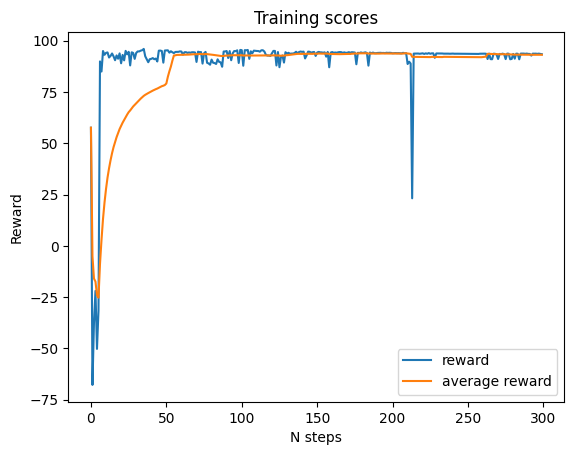

In [12]:
plot_reward(rewards,"Training scores")

####Agent testing

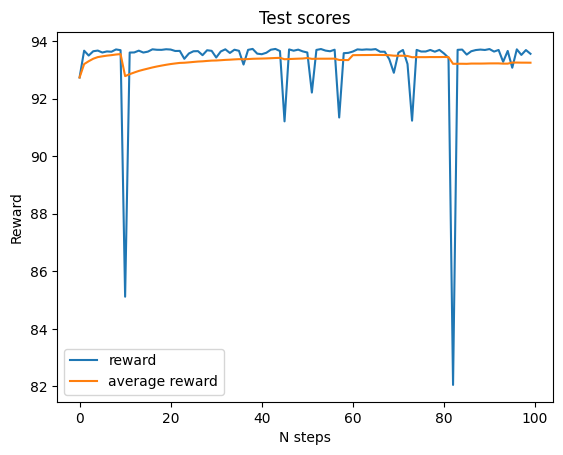

Mean score for 100 episodes: 93.31607588669881


In [13]:
test_agent(Agent,ENVIRONMENT)
env.close()

In [14]:
# Get a list of video files in the folder
video_files = [os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith(".mp4")]

# Load all video files as VideoFileClip objects
video_clips = [VideoFileClip(video) for video in sorted(video_files)]

# Combine all video clips
final_clip = concatenate_videoclips(video_clips)

# Save the final video
final_clip.write_videofile(output_video, codec="libx264", fps=24)

# Close the clips
for clip in video_clips:
    clip.close()
final_clip.close()

Moviepy - Building video output_combined_video.mp4.
Moviepy - Writing video output_combined_video.mp4



Moviepy - Done !
Moviepy - video ready output_combined_video.mp4


In [18]:
Video(output_video, embed=True)